In [1]:
import pvlib
import pandas as pd 
import matplotlib.pyplot as plt
import openpyxl
from datetime import datetime

In [3]:
# Function to get user input for the date
def get_user_date():
    date_str = input("Please enter the date for estimating the production (YYYY-MM-DD): ")
    try:
        date = datetime.strptime(date_str, "%Y-%m-%d")
        return date
    except ValueError:
        print("Invalid date format. Please enter the date in YYYY-MM-DD format.")
        return get_user_date()

# Load the data from the Excel file
file_path = r'D:\pv xl\Panels Per Lot 2023.xlsx'
data = pd.read_excel(file_path)

# Extract relevant columns for production calculation
lots = data['Lot']
arrays = data['Array']
modules = data['Modules']
tilt = data['Tilt']
azimuth = data['Azimuth']
inverters = data['Inverters']
panels_per_inverter = data['Panels/Inverter']
strings_per_inverter = data['Strings/Inverter']
panels_per_string = data['Panels/String']
panel_power = data['Panel Power']
array_power_per_inverter = data['Array Power/Inverter']
overload_ratio = data['Overload Ratio']
panel_age = data['Panel Age']  # 'Panel Age' column is added to the Excel file

# Define the required SAPM parameters
sapm_parameters = {
    'A0': 0.928, 'A1': -0.017, 'A2': -0.004, 'A3': 0.002, 'A4': -0.0001,
    'B0': 1.0, 'B1': -0.002, 'B2': 0.002, 'B3': -0.0001, 'B4': 0.00001,
    'B5': -0.000001, 'C0': 1.012, 'C1': -0.012, 'C2': 0.001, 'C3': -0.0001,
    'C4': 0.00001, 'C5': -0.000001, 'C6': 1.014, 'C7': -0.014,
    'FD': 1.0, 'N': 72, 'Voco': 45.6, 'Vmpo': 37.2, 'Isc': 9.5,
    'Imp': 8.8, 'Aisc': 0.002, 'Aimp': 0.002, 'Mbvoc': -0.002,
    'Mbvmp': -0.002, 'Bvoco': -0.002, 'Bvmpo': -0.002,
    'Cells_in_Series': 72, 'Impo': 8.8, 'Isco': 9.5, 'IXXO': 9.5, 'IXO': 8.8
}

# Set the location
location = pvlib.location.Location(latitude=37.978136, longitude=-121.312537, 
                                   name='University of the Pacific', altitude=6, tz='Etc/GMT+7')

# Get user input for the date
date = get_user_date()

# Set the day to estimate the production
times = pd.date_range(date.strftime('%Y-%m-%d'), freq='15min', periods=4*24, tz=location.tz)
clearsky = location.get_clearsky(times)

# Initialize lists to store PV systems and model chains
pv_systems = []
model_chains = []
lot_productions = {}

# Define degradation parameters 
gamma = -0.0045  # Temperature degradation coefficient 
alpha_0 = 2  # Year 1 degradation  
alpha_P = 0.54  # Power degradation coefficient  

# Iterate over each lot and array to create PV systems and model chains
for i in range(len(lots)):
    # Set the mount for each array
    mount = pvlib.pvsystem.FixedMount(surface_tilt=tilt[i], surface_azimuth=azimuth[i])
    
    # Set the module parameters based on array type
    module_parameters_name = 'Hanwha_Q_CELLS_Q_PEAK_DUO_L_G6_3_425' if arrays[i] == 'A' else 'Hanwha_Q_CELLS_Q_PEAK_DUO_L_G6_3_415'
    if module_parameters_name not in cec_modules.columns:
        raise KeyError(f"Module {module_parameters_name} not found in CEC database.")
    module_parameters = cec_modules[module_parameters_name]
    
    # Adjust panel power based on degradation formula
    eta_0 = module_parameters.STC / (module_parameters.Vmpo * module_parameters.Impo)  # Module conversion efficiency
    T_BOM = 45  # assuming of module temperature in Celsius (replace with actual value when available)
    t = panel_age[i]  # Module/system age
    
    eta_eff =  (alpha_0 + (t - 1) * alpha_P)
    adjusted_panel_power = eta_eff * module_parameters.STC
    
    # Set the inverter parameters
    inverter_parameters_name = 'Huawei_Technologies_Co___Ltd___SUN2000_40KTL_US__480V_'
    if inverter_parameters_name not in cec_inverters.columns:
        raise KeyError(f"Inverter {inverter_parameters_name} not found in CEC database.")
    inverter_parameters = cec_inverters[inverter_parameters_name]
    
    # Create PV system and model chain for each array
    array = pvlib.pvsystem.Array(mount, module_parameters=module_parameters,
                                 modules_per_string=panels_per_string[i],
                                 temperature_model_parameters=pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass'],
                                 strings=strings_per_inverter[i])
    
    pv_system = pvlib.pvsystem.PVSystem(arrays=[array], inverter_parameters=inverter_parameters)
    model_chain = pvlib.modelchain.ModelChain(pv_system, location, dc_model='sapm', ac_model='sandia', aoi_model='physical', spectral_model='no_loss')
    
    pv_systems.append(pv_system)
    model_chains.append(model_chain)

# Run the models for each model chain and calculate production for each lot
for i in range(len(model_chains)):
    mc = model_chains[i]
    mc.run_model(clearsky)
    
    lot_id = lots[i]
    if lot_id not in lot_productions:
        lot_productions[lot_id] = mc.results.ac
    else:
        lot_productions[lot_id] += mc.results.ac

# Plot total production for each individual lot
for lot_id in lot_productions:
    plt.figure()
    lot_productions[lot_id].plot(label=f'Lot {lot_id}')
    plt.ylabel('System Output (kW)')
    plt.xlabel('Time of Day')
    plt.title(f'Lot {lot_id} Production')
    plt.legend()
    plt.show()

# Combined plot to compare all lots
plt.figure()
for lot_id in lot_productions:
    lot_productions[lot_id].plot(label=f'Lot {lot_id}')
plt.ylabel('System Output (kW)')
plt.xlabel('Time of Day')
plt.title('Comparison of Lot Productions')
plt.legend()
plt.show()

# Save total production to CSV file for each lot
for lot_id in lot_productions:
    lot_productions[lot_id].to_csv(f'pvlib_lot{lot_id}_production report.csv')

print("Overall production calculation completed and saved to CSV files.")


Invalid date format. Please enter the date in YYYY-MM-DD format.


NameError: name 'cec_modules' is not defined

In [4]:
# Get the cec_modules and inverters databases
SAM_URL = "CEC Modules.csv"
cec_modules = pvlib.pvsystem.retrieve_sam(path=SAM_URL) 
cec_modules = cec_modules.drop('Manufacturer', axis=0)
cec_modules = cec_modules.loc[:, ~cec_modules.columns.duplicated()]
cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

# get the module and inverter specifications
module_parameters = [
    cec_modules['Hanwha_Q_CELLS_Q_PEAK_DUO_L_G6_3_425'],
    cec_modules['Hanwha_Q_CELLS_Q_PEAK_DUO_L_G6_3_415']
]
inverter_parameters = cec_inverters['Huawei_Technologies_Co___Ltd___SUN2000_40KTL_US__480V_']

d:\conda\envs\Uop-lib\lib\site-packages\pvlib\pvsystem.py:2095: UserWarning: Original names contain 29 duplicate(s).
  warnings.warn('Original names contain %d duplicate(s).' % n_duplicates)
d:\conda\envs\Uop-lib\lib\site-packages\pvlib\pvsystem.py:2099: UserWarning: Normalized names contain 29 duplicate(s).
  warnings.warn(


In [ ]:
#Modified inverter parameters due to datasheet updates and system derating
inverter_parameters.Vdco = 1000
inverter_parameters.Vdcmax = 1000
inverter_parameters.Idcmax = 88
inverter_parameters.Mppt_high = 1000
inverter_parameters.Mppt_low = 200
inverter_parameters.Paco = 36600.0 #all inverters are derated to 36.6 kW

In [ ]:
#Set common system parameters

# set the temperature model parameters
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']


In [ ]:
# Set Location Class
location = pvlib.location.Location(latitude = 37.978136, longitude = -121.312537, 
                                   name = 'University of the Pacific', altitude = 6, tz = 'Etc/GMT+7')

# Set Array Mounting Class
mount = [
    pvlib.pvsystem.FixedMount(surface_tilt = 7, surface_azimuth= 162), #0
    pvlib.pvsystem.FixedMount(surface_tilt = 7, surface_azimuth= 252), #1
    pvlib.pvsystem.FixedMount(surface_tilt = 7, surface_azimuth= 135), #2
    pvlib.pvsystem.FixedMount(surface_tilt = 7, surface_azimuth= 137), #3
    pvlib.pvsystem.FixedMount(surface_tilt = 7, surface_azimuth= 139), #4
    pvlib.pvsystem.FixedMount(surface_tilt = 7, surface_azimuth= 118)  #5
]

In [ ]:
# set the system array classes
lot1_array = [
    pvlib.pvsystem.Array(mount[0], module_parameters=module_parameters[0],  #mp1.1
                         modules_per_string=18, temperature_model_parameters=temperature_model_parameters, strings=7),
    pvlib.pvsystem.Array(mount[0], module_parameters=module_parameters[0],  #mp1.2
                         modules_per_string=18.5, temperature_model_parameters=temperature_model_parameters, strings=6),
    pvlib.pvsystem.Array(mount[0], module_parameters=module_parameters[0],  #mp1.3
                         modules_per_string=18.3333, temperature_model_parameters=temperature_model_parameters, strings=6),
    pvlib.pvsystem.Array(mount[0], module_parameters=module_parameters[0],  #mp1.4
                         modules_per_string=18, temperature_model_parameters=temperature_model_parameters, strings=6),
    pvlib.pvsystem.Array(mount[5], module_parameters=module_parameters[0],  #mp1.5.1
                         modules_per_string=18, temperature_model_parameters=temperature_model_parameters, strings=7),
    pvlib.pvsystem.Array(mount[5], module_parameters=module_parameters[0],  #mp1.5.2, 1.5.3
                         modules_per_string=17.8571, temperature_model_parameters=temperature_model_parameters, strings=7)
]

lot2_array = [
    pvlib.pvsystem.Array(mount[0], module_parameters=module_parameters[0],  #mp2.1, 2.2, 2.4, 2.5
                         modules_per_string=16.6667, temperature_model_parameters=temperature_model_parameters, strings=6)
]

lot3_array =[
    pvlib.pvsystem.Array(mount[0], module_parameters=module_parameters[1],  #mp3.1
                         modules_per_string=18.5, temperature_model_parameters=temperature_model_parameters, strings=6),
    pvlib.pvsystem.Array(mount[1], module_parameters=module_parameters[1],  #mp3.2
                         modules_per_string=18.3333, temperature_model_parameters=temperature_model_parameters, strings=6),
    pvlib.pvsystem.Array(mount[1], module_parameters=module_parameters[1],  #mp3.3, 3.4
                         modules_per_string=16.6667, temperature_model_parameters=temperature_model_parameters, strings=6)
]

lot4_array = [
    pvlib.pvsystem.Array(mount[0], module_parameters=module_parameters[0],  #mp4.1, 4.2
                         modules_per_string=18.5, temperature_model_parameters=temperature_model_parameters, strings=6),
    pvlib.pvsystem.Array(mount[0], module_parameters=module_parameters[0],  #mp4.3
                         modules_per_string=18, temperature_model_parameters=temperature_model_parameters, strings=7)
]

lot6_array = [
    pvlib.pvsystem.Array(mount[2], module_parameters=module_parameters[1],  #mp6.1
                         modules_per_string=18.5, temperature_model_parameters=temperature_model_parameters, strings=6),
    pvlib.pvsystem.Array(mount[2], module_parameters=module_parameters[1],  #mp6.2
                         modules_per_string=18.8571, temperature_model_parameters=temperature_model_parameters, strings=7),
    pvlib.pvsystem.Array(mount[2], module_parameters=module_parameters[1],  #mp6.3
                         modules_per_string=18.6667, temperature_model_parameters=temperature_model_parameters, strings=6)
]

lot7_array = [
    pvlib.pvsystem.Array(mount[1], module_parameters=module_parameters[1],  #mp7.1, 7.2
                         modules_per_string=16.5, temperature_model_parameters=temperature_model_parameters, strings=8),
    pvlib.pvsystem.Array(mount[1], module_parameters=module_parameters[1],  #mp7.3
                         modules_per_string=18, temperature_model_parameters=temperature_model_parameters, strings=6),
    pvlib.pvsystem.Array(mount[1], module_parameters=module_parameters[1],  #mp7.4
                         modules_per_string=18.6, temperature_model_parameters=temperature_model_parameters, strings=5),
    pvlib.pvsystem.Array(mount[0], module_parameters=module_parameters[1],  #mp7.5
                         modules_per_string=18.3333, temperature_model_parameters=temperature_model_parameters, strings=6),
    pvlib.pvsystem.Array(mount[3], module_parameters=module_parameters[1],  #mp7.6, 7.7
                         modules_per_string=16.6667, temperature_model_parameters=temperature_model_parameters, strings=6),
    pvlib.pvsystem.Array(mount[4], module_parameters=module_parameters[1],  #mp7.8
                         modules_per_string=15.6, temperature_model_parameters=temperature_model_parameters, strings=5),
    pvlib.pvsystem.Array(mount[3], module_parameters=module_parameters[1],  #mp7.9
                         modules_per_string=17.3333, temperature_model_parameters=temperature_model_parameters, strings=6)
]

lot9_array = [
    pvlib.pvsystem.Array(mount[0], module_parameters=module_parameters[0],  #mp9.1, 9.2
                         modules_per_string=18, temperature_model_parameters=temperature_model_parameters, strings=6),
    pvlib.pvsystem.Array(mount[0], module_parameters=module_parameters[0],  #mp9.3, 9.4
                         modules_per_string=18.4286, temperature_model_parameters=temperature_model_parameters, strings=7)
]

lot10a_array = [
    pvlib.pvsystem.Array(mount[0], module_parameters=module_parameters[1],  #mp10.1, 10.2, 10.3, 10.6, 10.10
                         modules_per_string=18.8571, temperature_model_parameters=temperature_model_parameters, strings=7),
    pvlib.pvsystem.Array(mount[0], module_parameters=module_parameters[1],  #mp10.4.7-9, 10.5.12,14,15
                         modules_per_string=18.4286, temperature_model_parameters=temperature_model_parameters, strings=7),
    pvlib.pvsystem.Array(mount[0], module_parameters=module_parameters[1],  #mp10.4.17, 10.5.13
                         modules_per_string=18.5, temperature_model_parameters=temperature_model_parameters, strings=6)
]

lot10b_array = [
    pvlib.pvsystem.Array(mount[0], module_parameters=module_parameters[1],  #mp10.7, 10.8, 10.9, 10.11
                         modules_per_string=18.8571, temperature_model_parameters=temperature_model_parameters, strings=7),
    pvlib.pvsystem.Array(mount[0], module_parameters=module_parameters[1],  #mp10.12
                         modules_per_string=18.5, temperature_model_parameters=temperature_model_parameters, strings=6)
]


In [ ]:
# losses
losses_parameters = dict(shading=0, availability=0)

# set the PV System class
lot1_system = [
    pvlib.pvsystem.PVSystem(lot1_array[0], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters),
    pvlib.pvsystem.PVSystem(lot1_array[1], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters),
    pvlib.pvsystem.PVSystem(lot1_array[2], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters),
    pvlib.pvsystem.PVSystem(lot1_array[3], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters),
    pvlib.pvsystem.PVSystem(lot1_array[4], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters),
    pvlib.pvsystem.PVSystem(lot1_array[5], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters)
]

lot2_system = [
    pvlib.pvsystem.PVSystem(lot2_array[0], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters)
]

lot3_system = [
    pvlib.pvsystem.PVSystem(lot3_array[0], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters),
    pvlib.pvsystem.PVSystem(lot3_array[1], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters),
    pvlib.pvsystem.PVSystem(lot3_array[2], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters)
]

lot4_system = [
    pvlib.pvsystem.PVSystem(lot4_array[0], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters),
    pvlib.pvsystem.PVSystem(lot4_array[1], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters)
]

lot6_system = [
    pvlib.pvsystem.PVSystem(lot6_array[0], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters),
    pvlib.pvsystem.PVSystem(lot6_array[1], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters),
    pvlib.pvsystem.PVSystem(lot6_array[2], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters)
]

lot7_system = [
    pvlib.pvsystem.PVSystem(lot7_array[0], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters),
    pvlib.pvsystem.PVSystem(lot7_array[1], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters),
    pvlib.pvsystem.PVSystem(lot7_array[2], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters),
    pvlib.pvsystem.PVSystem(lot7_array[3], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters),
    pvlib.pvsystem.PVSystem(lot7_array[4], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters),
    pvlib.pvsystem.PVSystem(lot7_array[5], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters),
    pvlib.pvsystem.PVSystem(lot7_array[6], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters)
]

lot9_system = [
    pvlib.pvsystem.PVSystem(lot9_array[0], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters),
    pvlib.pvsystem.PVSystem(lot9_array[1], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters)
]

lot10a_system = [
    pvlib.pvsystem.PVSystem(lot10a_array[0], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters),
    pvlib.pvsystem.PVSystem(lot10a_array[1], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters),
    pvlib.pvsystem.PVSystem(lot10a_array[2], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters)
]

lot10b_system = [
    pvlib.pvsystem.PVSystem(lot10b_array[0], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters),
    pvlib.pvsystem.PVSystem(lot10b_array[1], inverter_parameters=inverter_parameters, losses_parameters=losses_parameters)
]

In [ ]:
mc = [
    pvlib.modelchain.ModelChain(lot1_system[0], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #0
    pvlib.modelchain.ModelChain(lot1_system[1], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #1
    pvlib.modelchain.ModelChain(lot1_system[2], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #2
    pvlib.modelchain.ModelChain(lot1_system[3], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #3
    pvlib.modelchain.ModelChain(lot1_system[4], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #4
    pvlib.modelchain.ModelChain(lot1_system[5], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #5

    pvlib.modelchain.ModelChain(lot2_system[0], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #6

    pvlib.modelchain.ModelChain(lot3_system[0], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #7
    pvlib.modelchain.ModelChain(lot3_system[1], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #8
    pvlib.modelchain.ModelChain(lot3_system[2], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #9

    pvlib.modelchain.ModelChain(lot4_system[0], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #10
    pvlib.modelchain.ModelChain(lot4_system[1], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #11

    pvlib.modelchain.ModelChain(lot6_system[0], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #12
    pvlib.modelchain.ModelChain(lot6_system[1], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #13
    pvlib.modelchain.ModelChain(lot6_system[2], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #14

    pvlib.modelchain.ModelChain(lot7_system[0], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #15
    pvlib.modelchain.ModelChain(lot7_system[1], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #16
    pvlib.modelchain.ModelChain(lot7_system[2], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #17
    pvlib.modelchain.ModelChain(lot7_system[3], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #18
    pvlib.modelchain.ModelChain(lot7_system[4], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #19
    pvlib.modelchain.ModelChain(lot7_system[5], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #20
    pvlib.modelchain.ModelChain(lot7_system[6], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #21

    pvlib.modelchain.ModelChain(lot9_system[0], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #22
    pvlib.modelchain.ModelChain(lot9_system[1], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #23

    pvlib.modelchain.ModelChain(lot10a_system[0], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #24
    pvlib.modelchain.ModelChain(lot10a_system[1], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #25
    pvlib.modelchain.ModelChain(lot10a_system[2], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #26

    pvlib.modelchain.ModelChain(lot10b_system[0], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #27
    pvlib.modelchain.ModelChain(lot10b_system[1], location, aoi_model='physical', spectral_model='no_loss'), # losses_model='pvwatts' #28
]

In [ ]:
#Set the day to estimate the production
times = pd.date_range('07-01-2023', freq='15min', periods=4*24, tz=location. tz)
clearsky = location.get_clearsky(times)

In [ ]:
#Run the Models
for x in range(len(mc)):
    mc[x].run_model(clearsky)

In [ ]:
#Production Calculations
prod = [
    4*mc[0].results.ac + 4*mc[1].results.ac + 3*mc[2].results.ac + 2*mc[3].results.ac
        + 1*mc[4].results.ac + 2*mc[5].results.ac,                                          #0: lot 1
    3*4*mc[6].results.ac,                                                                   #1: lot 2
    4*mc[7].results.ac + 3*mc[8].results.ac + 3*2*mc[9].results.ac,                         #2: lot 3
    2*4*mc[10].results.ac + 4*mc[11].results.ac,                                            #3: lot 4
    4*mc[12].results.ac + 2*mc[13].results.ac + 3*mc[14].results.ac,                        #4: lot 6
    2*2*mc[15].results.ac + 2*mc[16].results.ac + 2*mc[17].results.ac + 3*mc[18].results.ac 
        + 3*mc[19].results.ac + 1*mc[20].results.ac + 1*mc[21].results.ac,                  #5: lot 7
    2*mc[22].results.ac + 2*mc[23].results.ac,                                              #6: lot 9
    9*mc[24].results.ac + 6*mc[25].results.ac + 2*mc[26].results.ac,                        #7: lot 10a
    8*mc[27].results.ac + 4*mc[28].results.ac,                                              #8: lot 10b
]


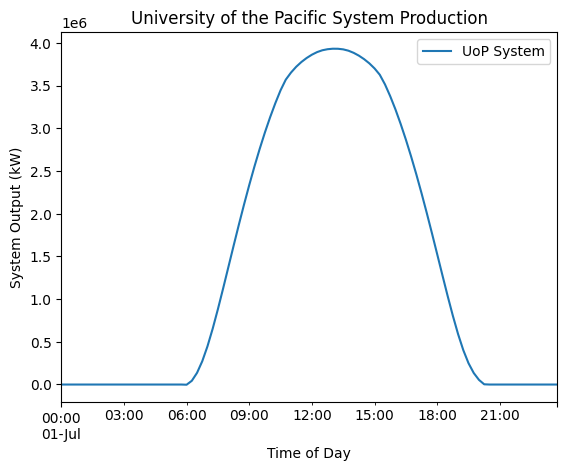

In [ ]:

total_prod = sum(prod)
#Plot Data
total_prod.plot(label='UoP System')
plt.ylabel('System Output (kW)')
plt.xlabel('Time of Day')
plt.title('University of the Pacific System Production')
plt.legend()
plt.show()


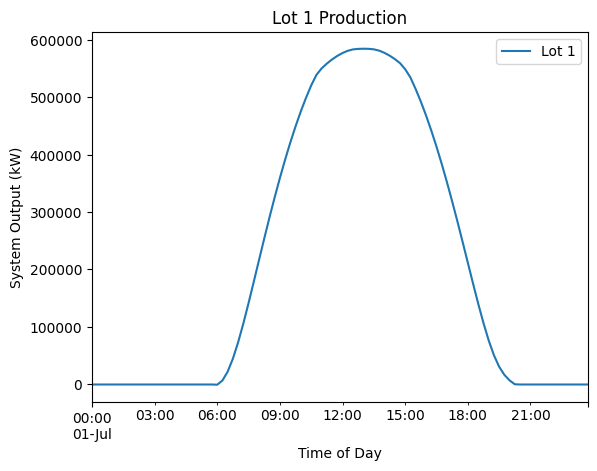

In [ ]:
#Save data into csv file
prod[0].to_csv('pvlib_lot1_july1.csv') #should update this with automatic file name generation

#Plot Data
prod[0].plot(label='Lot 1')
plt.ylabel('System Output (kW)')
plt.xlabel('Time of Day')
plt.title('Lot 1 Production')
plt.legend()
plt.show()

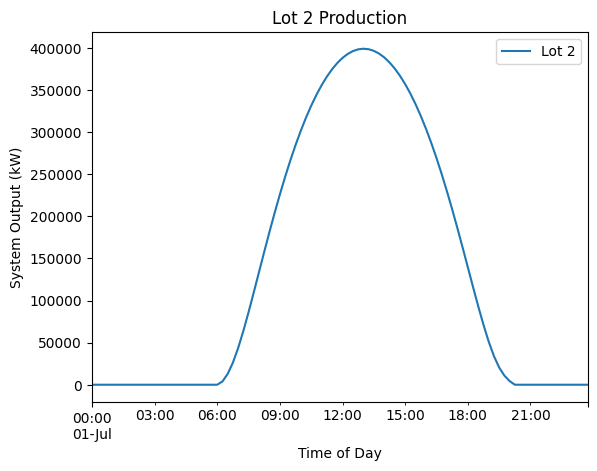

In [ ]:
#Save data into csv file
prod[1].to_csv('pvlib_lot2_july1.csv') #should update this with automatic file name generation

#Plot Data
prod[1].plot(label='Lot 2')
plt.ylabel('System Output (kW)')
plt.xlabel('Time of Day')
plt.title('Lot 2 Production')
plt.legend()
plt.show()

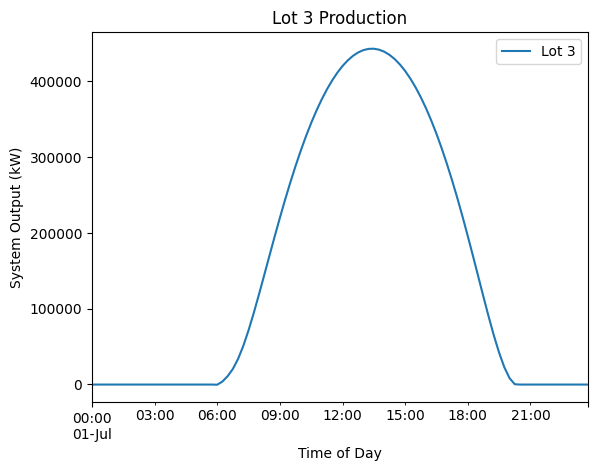

In [ ]:
#Save data into csv file
prod[2].to_csv('pvlib_lot3_july1.csv') #should update this with automatic file name generation

#Plot Data
prod[2].plot(label='Lot 3')
plt.ylabel('System Output (kW)')
plt.xlabel('Time of Day')
plt.title('Lot 3 Production')
plt.legend()
plt.show()

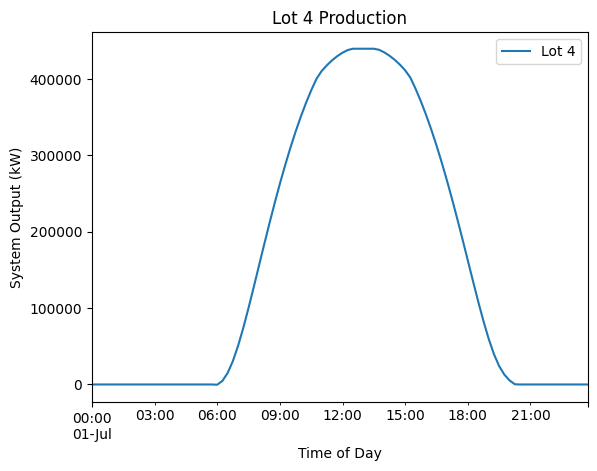

In [ ]:
#Save data into csv file
prod[3].to_csv('pvlib_lot4_july1.csv') #should update this with automatic file name generation

#Plot Data
prod[3].plot(label='Lot 4')
plt.ylabel('System Output (kW)')
plt.xlabel('Time of Day')
plt.title('Lot 4 Production')
plt.legend()
plt.show()

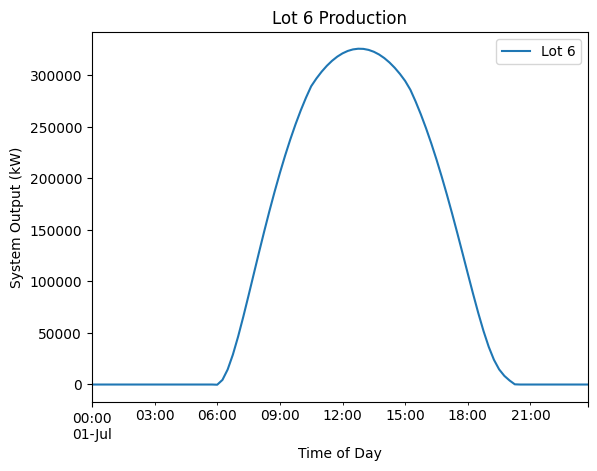

In [ ]:
#Lot 6
#Save data into csv file
prod[4].to_csv('pvlib_lot6_july1.csv') #should update this with automatic file name generation

#Plot Data
prod[4].plot(label='Lot 6')
plt.ylabel('System Output (kW)')
plt.xlabel('Time of Day')
plt.title('Lot 6 Production')
plt.legend()
plt.show()

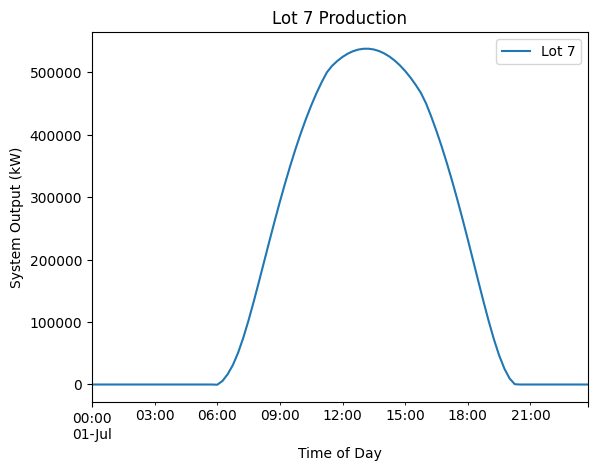

In [ ]:
#Lot 7
#Save data into csv file
prod[5].to_csv('pvlib_lot7_july1.csv') #should update this with automatic file name generation

#Plot Data
prod[5].plot(label='Lot 7')
plt.ylabel('System Output (kW)')
plt.xlabel('Time of Day')
plt.title('Lot 7 Production')
plt.legend()
plt.show()

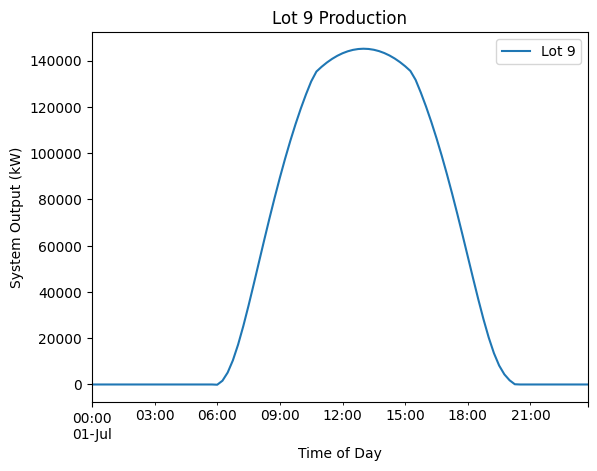

In [ ]:
#Lot 9
#Save data into csv file
prod[6].to_csv('pvlib_lot9_july1.csv') #should update this with automatic file name generation

#Plot Data
prod[6].plot(label='Lot 9')
plt.ylabel('System Output (kW)')
plt.xlabel('Time of Day')
plt.title('Lot 9 Production')
plt.legend()
plt.show()

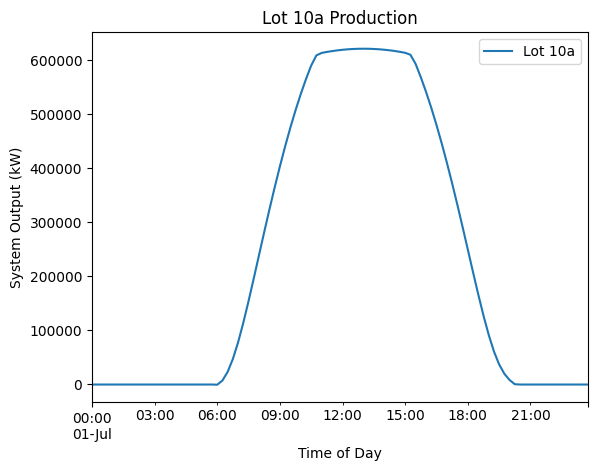

In [ ]:
#Lot 10a
#Save data into csv file
prod[7].to_csv('pvlib_lot10a_july1.csv') #should update this with automatic file name generation

#Plot Data
prod[7].plot(label='Lot 10a')
plt.ylabel('System Output (kW)')
plt.xlabel('Time of Day')
plt.title('Lot 10a Production')
plt.legend()
plt.show()

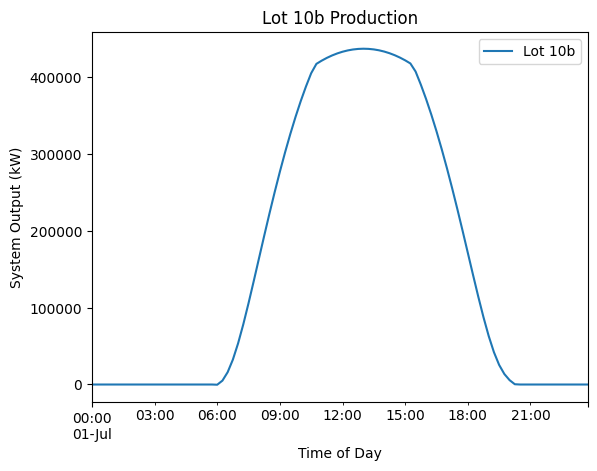

In [ ]:
#Lot 10b
#Save data into csv file
prod[8].to_csv('pvlib_lot10b_july1.csv') #should update this with automatic file name generation

#Plot Data
prod[8].plot(label='Lot 10b')
plt.ylabel('System Output (kW)')
plt.xlabel('Time of Day')
plt.title('Lot 10b Production')
plt.legend()
plt.show()

In [ ]:
# Fetch weather data
# ------------------
# Use weather data taken from the NSRDB PSM3 for the year
# 2023.

# api_key = 'lNchMCSOEzggsbHeDy7kCAkg9VC0UrUJEVyx0uFZ'
# email = 'dmueller@pacific.edu'

# keys = ['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed',
#         'albedo', 'precipitable_water']

# psm3, psm3_metadata = pvlib.iotools.get_psm3(
#     latitude, 
#     longitude, 
#     api_key,
#     email, 
#     interval=15, 
#     names=2022,                                         
#     map_variables=True, 
#     leap_day=True,
#     attributes=keys
# )